<a href="https://colab.research.google.com/github/m7saikat/IE-7374/blob/master/Lab_2(e)_MABs_UCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2-e  Multi-armed Bandits - Upper Confidence Bound (UCB)

## 1 - Introduction

Exploration is needed because there is always uncertainty about the accuracy of the action-value estimates. The greedy actions are those that look best at present, but some of the other actions may actually be better. ε-greedy action selection forces the non-greedy actions to be tried, but indiscriminately, with no preference for those that are nearly greedy or particularly uncertain. It would be better to select among the non-greedy actions according to their potential for actually being optimal, taking into account both how close their estimates are to being maximal and the uncertainties in those estimates. One eﬀective way of doing this is to select actions according to

$A_t \dot=\left[Q_t + c\sqrt\frac{log_e t}{N_t(a)}\right]$

where $log_et$ denotes the natural logarithm of $t$ , $N_t(a)$ denotes the number of times that action a has been selected prior to time $t$, and the number $c > 0$ controls the degree of exploration. If $N_t(a) = 0$, then $a$ is considered to be a maximizing action. 

The idea of this upper conﬁdence bound (UCB) action selection is that the square-root term which is a measure of the uncertainty or variance in the estimate of $a$’s value. The quantity being max’ed over is thus a sort of upper bound on the possible true value of action a, with c determining the conﬁdence level. Each time a is selected the uncertainty is presumably reduced: $N_t(a)$ increments, and, as it appears in the denominator, the uncertainty term decreases. On the other hand, each time an action other than a is selected, t increases but $N_t(a)$ does not; because $t$ appears in the numerator, the uncertainty estimate increases. The use of the natural logarithm means that the increases get smaller over time, but are unbounded; all actions will eventually be selected, but actions with lower value estimates, or that have already been selected frequently, will be selected with decreasing frequency over time. 

In this lab we have tried to compare the results of greedy with UCB on the 10-armed testbed.

### Importing Libraries
---


In [0]:
import numpy as np
import matplotlib.pyplot as plt

## 2 - Problem definition

### Expected initial action value
---


In [0]:
# This function generates the true value of actions
def expected_action_value_function(mu=0, scale=1, arms=10):
    expected_action_value = np.random.normal(mu, scale , arms)
    return expected_action_value

### Adding randomness to the expected action values
---



In [0]:
def update_expected_action_value(expected_action_value):
    expected_action_value += np.random.normal(0, 0.01, arms) 
    return(expected_action_value)

### Reward function
---


In [0]:
def reward_function(action_taken, expected_action_value,scale=1):
  reward = expected_action_value [action_taken] + np.random.normal(scale) # reward=N(Mu,1) or Mu+N(0,1)
  return reward

## 3 - Implementation

### Methods 1:  <span style="color:blue">$\epsilon-greedy$</span>  function 

---

In [0]:
def get_action_greedy(estimate_action_value, e, arms, action_count):
  # genereate a random num (0,1) to be compared with epsilon
  e_estimator = np.random.uniform(0, 1) 
 
  # epsilon-greedy appraoch
  action = np.argmax(estimate_action_value) if e_estimator > e else np.random.choice(np.arange(arms))

  return action

### Methods 2:  <span style="color:red">Upper Confidence Bound (UCB)</span>  function 

In [0]:
def get_action_ucb(estimate_action_value, e, arms, count, c=2):  
  # genereate a random num (0,1) to be compared with epsilon
  e_estimator = np.random.uniform(0, 1) 
 
  # UCB Approach: changing the way action is being selected.
  if e_estimator > e:
    t = np.sum(count) + 1
    q = estimate_action_value + c * np.sqrt(np.log(t) / (count + 1e-6)) 
    action = np.argmax(q)  
  else:
    action = np.random.choice(np.arange(arms))
  return action

### Action Value estimation- Method 1: Weighted Average approach

---

In [0]:
# Define estimate_action_value function (using weighted average method)
def weighted_average (estimate_action_value, action, reward, alpha):
    estimate_action_value[action] = estimate_action_value[action] + alpha * (reward - estimate_action_value[action])
    return estimate_action_value

### The k-armed bandit problem
---


In [0]:
def multi_arm_bandit_problem(alpha = 0.1, arms = 10, steps = 1000, epsilon = 0.1, expected_action_value = [],scale=1, typ = '' ):
   
    # Initilization 
    overall_reward, optimal_action = [], [] 

    # Initial Action values is set to zero 
    estimate_action_value = np.zeros(arms)

    #number of times is action (arm) is taken 
    count = np.zeros(arms) 

    # Adding randomness to the action value for each bandit problem,
    # thus simulating variable rewards over time. This segment makes a stationary
    # reward system, non-stationary.
    expected_action_value = update_expected_action_value(expected_action_value) 

    # Main loop
    for s in range(0, steps):

        # Select an action based on type of problem
        if typ == greedy:
          action = get_action_greedy(estimate_action_value,epsilon, arms, count)
        elif typ == ucb:
          action = get_action_ucb(estimate_action_value,epsilon, arms, count)

        # Observe the reward for the selected Action
        reward = reward_function(action, expected_action_value,scale)

        # Update Estimates of Action Value for the selected Action based on its observed Reward
        estimate_action_value=weighted_average(estimate_action_value, action, reward, alpha)
        
        # Update rewards' list
        overall_reward.append(reward)

        # If the optimal action is taken
        optimal_action.append(action == np.argmax(expected_action_value))

        # Increment the number of times the selected action is takern
        count[action] += 1
        
    return overall_reward, optimal_action

### Multi-arm testbed

---

In [0]:
def run_game(alpha, epsilon, runs = 10, steps = 1000, arms = 10, typ = ''):
    rewards = np.zeros((runs, steps))
    optimal_actions = np.zeros((runs, steps))
    expected_action_value = expected_action_value_function(0, 1, arms)
    for run in range(0, runs):
      rewards[run][:], optimal_actions[run][:] = multi_arm_bandit_problem( alpha = alpha, 
                                                                            arms = arms, 
                                                                            steps = steps,
                                                                            epsilon = epsilon,
                                                                            expected_action_value = expected_action_value,
                                                                            scale = 1,
                                                                            typ = typ)
    rewards_avg = np.average(rewards, axis = 0)
    optimal_action_perc = np.average(optimal_actions, axis = 0)
    return(rewards_avg, optimal_action_perc)

### Plotting the reward performance and optimal action percentage of the agents with different epsilon values.


---


1. The UCB agent: Orange 
2. The Greedy agent : Blue 


In [0]:
# Number of arms of bandits.
arms=10

# Numner of episodes in each run
steps = 1000

# Total number of runs
runs = 2000   

# The epsilon value for both the plots
epsilon = 0.1

# Step size  
alpha=0.1

# Degree of exploration for UCB
c = 2

# Default type 
typ = 'greedy'

# Bandit types
greedy = 'greedy'
ucb = 'ucb'

In [0]:
# Running the Experiment for different Scenarios
rewards_avg_by_epsilon = dict()
rewards_by_different_argmax = dict()

# For epsilon greedy
print('Running for {} epsilon {}...'.format(greedy, epsilon))
rewards_avg, optimal_action_perc = run_game(alpha, epsilon, runs, steps, arms, greedy)
rewards_by_different_argmax["greedy"] = rewards_avg

# For Upper confidence bound
print('Running for {} with c = 2 ...'.format(ucb))
rewards_avg, optimal_action_perc = run_game(alpha, epsilon, runs, steps, arms, ucb)
rewards_by_different_argmax["UCB"] = rewards_avg
print('Experiment is complete') 


Running for greedy epsilon 0.1...
Running for ucb with c = 2 ...
Experiment is complete


Once we have the reward performance and optimal action from the test bed, we can now plot the graphs using the in-built function `plot` of matplotlib.

(0, 3)

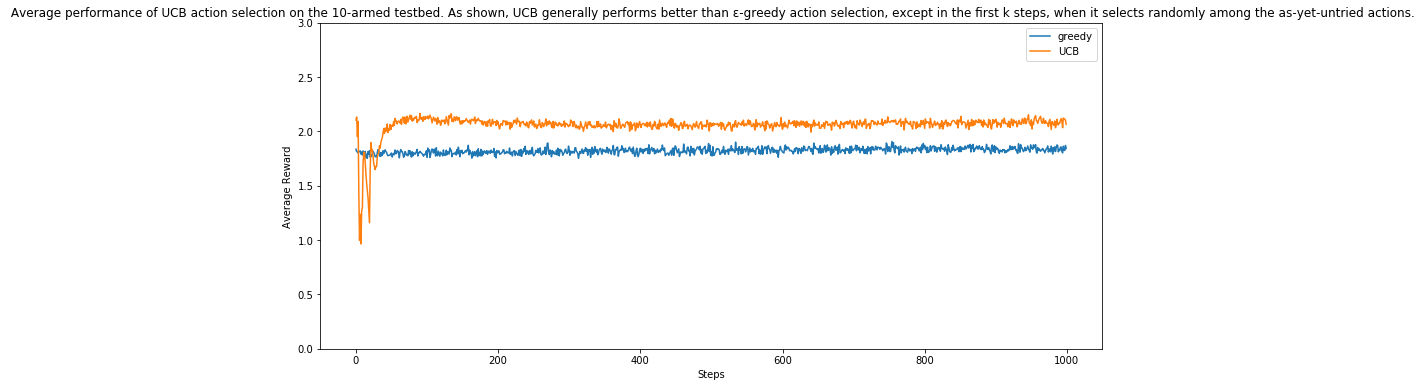

In [0]:
f, ax = plt.subplots(figsize=(14, 6))
for bandit in rewards_by_different_argmax:
    ax.plot(range(steps), rewards_by_different_argmax[bandit], label=bandit)
ax.legend()
plt.title(' Average performance of UCB action selection on the 10-armed testbed. \
As shown, UCB generally performs better than ε-greedy action selection, except \
in the ﬁrst k steps, when it selects randomly among the as-yet-untried actions.')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
ax.set_ylim(0, 3  ) #Max for 100%
